In [1]:
from typing import Optional

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"

# Define the path to the data file
# The file 'final_papers_with_metadata.xlsx' is in the same folder as this notebook (Analysis folder).
file_path = 'final_papers_with_metadata.xlsx'

# Load the data into a pandas DataFrame
try:
    df_papers = pd.read_excel(file_path)
    print(f"Successfully loaded data from {file_path}. Shape: {df_papers.shape}")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the path and filename.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")



Successfully loaded data from final_papers_with_metadata.xlsx. Shape: (46, 15)


In [2]:
def column_value_frequencies(df: pd.DataFrame, column: str, dropna: bool = False) -> dict:
    """Return a mapping of unique values in a column to their frequency.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data.
    column : str
        The column name to analyse.
    dropna : bool, default False
        When True, missing values are excluded from the frequency count.

    Returns
    -------
    dict
        Dictionary mapping each unique value to its frequency count.
    """
    if column not in df.columns:
        raise KeyError(f"Column '{column}' not found in DataFrame.")

    counts = df[column].value_counts(dropna=dropna)
    return counts.to_dict()


In [3]:
def plot_bar_from_dict(
    data: dict,
    x_label: str,
    y_label: str,
    title: str,
    *,
    sort_by: Optional[str] = "value",
    ascending: bool = False,
    color: str = "#4d4d4d",
    edgecolor: str = "#000000",
    annotate: bool = True,
    figsize: tuple = (10, 6),
    title_fontsize: Optional[int] = None,
    label_fontsize: Optional[int] = None,
    tick_label_fontsize: Optional[int] = None,
    annotation_fontsize: Optional[int] = None,
):
    """Plot a bar chart from a dictionary of counts.

    Parameters
    ----------
    data : dict
        Mapping of labels to numeric values.
    x_label : str
        Label for the x-axis.
    y_label : str
        Label for the y-axis.
    title : str
        Plot title.
    sort_by : {"value", "key", None}, default "value"
        Sort the bars by dictionary values or keys before plotting. If None,
        preserve the order of the dictionary.
    ascending : bool, default False
        Sort order for the bars.
    color : str, default "#4d4d4d"
        Fill color for the bars (use greyscale for print-friendly output).
    edgecolor : str, default "#000000"
        Edge color for the bars.
    annotate : bool, default True
        If True, add the count above each bar.
    figsize : tuple, default (10, 6)
        Figure size passed to Matplotlib.
    title_fontsize : int, optional
        Font size for the plot title.
    label_fontsize : int, optional
        Font size for the x and y axis labels.
    tick_label_fontsize : int, optional
        Font size for the x and y axis tick labels.
    annotation_fontsize : int, optional
        Font size for the bar value annotations.

    Returns
    -------
    matplotlib.axes.Axes
        The matplotlib Axes object containing the bar plot.
    """
    if not data:
        raise ValueError("The input dictionary is empty; nothing to plot.")

    items = list(data.items())

    if sort_by is not None:
        normalized_sort_by = sort_by.lower()
        if normalized_sort_by not in {"value", "key"}:
            raise ValueError("sort_by must be either 'value', 'key', or None.")
        reverse = not ascending
        if normalized_sort_by == "value":
            items.sort(key=lambda item: item[1], reverse=reverse)
        else:
            items.sort(key=lambda item: item[0], reverse=reverse)

    labels, values = zip(*items)
    positions = range(len(labels))

    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(positions, values, color=color, edgecolor=edgecolor)

    ax.set_xticks(list(positions))
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=tick_label_fontsize)
    ax.set_xlabel(x_label, fontsize=label_fontsize)
    ax.set_ylabel(y_label, fontsize=label_fontsize)
    ax.set_title(title, fontsize=title_fontsize)

    # Set y-axis tick label font size
    ax.tick_params(axis='y', labelsize=tick_label_fontsize)

    max_value = max(values)
    if max_value > 0:
        upper_limit = max_value + max(1, max_value * 0.15)
    else:
        upper_limit = 1
    ax.set_ylim(0, upper_limit)

    if annotate:
        for bar, value in zip(bars, values):
            ax.annotate(
                f"{value}",
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 4),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=annotation_fontsize,
            )

    ax.grid(axis="y", color="#bfbfbf", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.tight_layout()
    return ax



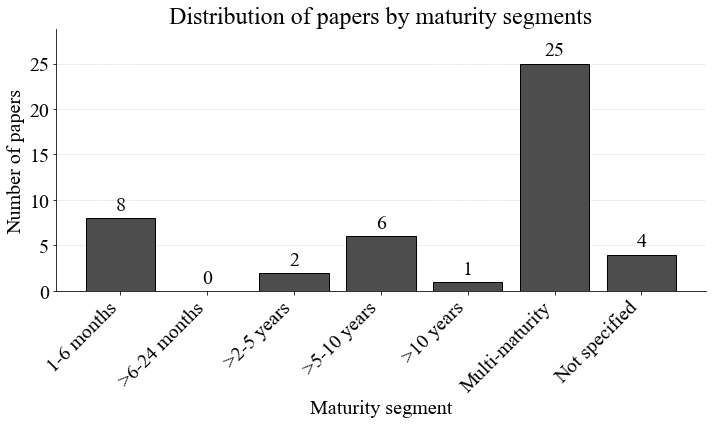

In [4]:
# Example usage: compute maturity-segment frequencies and standardize labels
maturity_segment_standardization_map = {
    "very short": "1-6 months",
    "short": ">6-24 months",
    "medium": ">2-5 years",
    "long": ">5-10 years",
    "very long": ">10 years",
    "multi": "Multi-maturity",
    "not specified": "Not specified",
}

canonical_maturity_labels = [
    "1-6 months",
    ">6-24 months",
    ">2-5 years",
    ">5-10 years",
    ">10 years",
    "Multi-maturity",
    "Not specified",
]

maturity_frequencies_raw = column_value_frequencies(df_papers, 'Maturity segment', dropna=False)

maturity_frequencies_standardized = {label: 0 for label in canonical_maturity_labels}
for raw_label, count in maturity_frequencies_raw.items():
    # Skip any accidental header-like values
    if isinstance(raw_label, str) and raw_label.strip().lower() == "maturity segment":
        continue

    if pd.isna(raw_label):
        normalized_key = "Not specified"
    else:
        normalized_key = maturity_segment_standardization_map.get(
            str(raw_label).strip().lower(),
            "Not specified",
        )
    maturity_frequencies_standardized[normalized_key] = maturity_frequencies_standardized.get(normalized_key, 0) + count

# Plot the distribution of maturity segments
plot_bar_from_dict(
    maturity_frequencies_standardized,
    x_label="Maturity segment",
    y_label="Number of papers",
    title="Distribution of papers by maturity segments",
    sort_by=None,
    title_fontsize=24,
    label_fontsize=20,
    tick_label_fontsize=20,
    annotation_fontsize=20,

)
plt.show()



{'U.S.': 20, 'Emerging': 14, 'Cross-country': 6, 'Developed': 6}


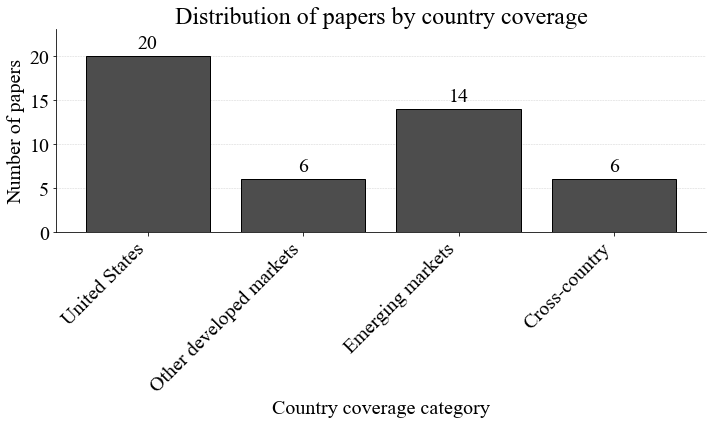

In [5]:
# Example usage: compute maturity-segment frequencies and standardize labels
country_segment_standardization_map = {
    "u.s.": "United States", # Changed to lowercase to match raw_label.strip().lower()
    "developed": "Other developed markets", # Changed to lowercase
    "emerging": "Emerging markets", # Changed to lowercase
    "cross-country": "Cross-country", # Changed to lowercase
}

canonical_country_labels = [
    "United States",
    "Other developed markets",
    "Emerging markets",
    "Cross-country",
]

country_frequencies_raw = column_value_frequencies(df_papers, 'Country classification', dropna=False)
print(country_frequencies_raw)

country_frequencies_standardized = {label: 0 for label in canonical_country_labels}
for raw_label, count in country_frequencies_raw.items():
    # Get the standardized key. If the raw_label is not found in the map,
    # .get() will return None by default.
    # The map keys are now lowercase, so this lookup will work correctly.
    normalized_key = country_segment_standardization_map.get(raw_label.strip().lower())
    
    # Only add to the standardized frequencies if a valid, mapped key was found.
    # This prevents 'None' or any unmapped categories from being added.
    if normalized_key:
        country_frequencies_standardized[normalized_key] = country_frequencies_standardized.get(normalized_key, 0) + count

# Plot the distribution of countries
plot_bar_from_dict(
    country_frequencies_standardized,
    x_label="Country coverage category",
    y_label="Number of papers",
    title="Distribution of papers by country coverage",
    sort_by=None,
    title_fontsize=24,
    label_fontsize=20,
    tick_label_fontsize=20,
    annotation_fontsize=20,

)
plt.show()

{'Yield forecasting': 24, 'Interest rate/short rate': 11, 'Excess returns': 10, 'Raw returns': 1}


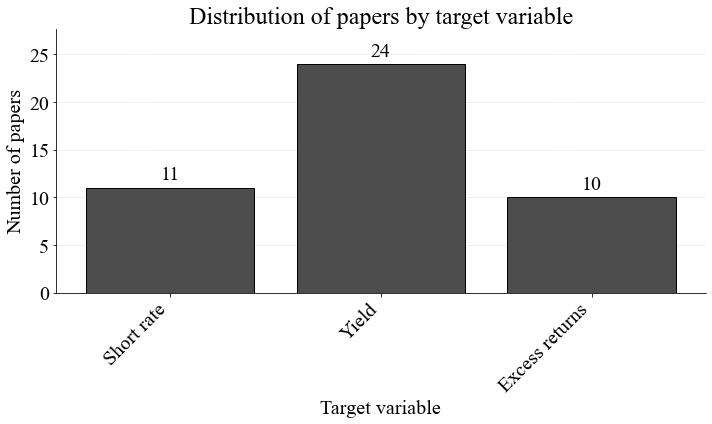

In [6]:
# Categorize by target variable
# Example usage: compute maturity-segment frequencies and standardize labels
country_segment_standardization_map = {
    "interest rate/short rate": "Short rate", # Changed to lowercase to match raw_label.strip().lower()
    "yield forecasting": "Yield", # Changed to lowercase
    "excess returns": "Excess returns", #  # Changed to lowercase
}

canonical_country_labels = [
    "Short rate",
    "Yield",
    "Excess returns",
]

country_frequencies_raw = column_value_frequencies(df_papers, 'Target', dropna=False)
print(country_frequencies_raw)

country_frequencies_standardized = {label: 0 for label in canonical_country_labels}
for raw_label, count in country_frequencies_raw.items():
    # Get the standardized key. If the raw_label is not found in the map,
    # .get() will return None by default.
    # The map keys are now lowercase, so this lookup will work correctly.
    normalized_key = country_segment_standardization_map.get(raw_label.strip().lower())
    
    # Only add to the standardized frequencies if a valid, mapped key was found.
    # This prevents 'None' or any unmapped categories from being added.
    if normalized_key:
        country_frequencies_standardized[normalized_key] = country_frequencies_standardized.get(normalized_key, 0) + count

# Plot the distribution of countries
plot_bar_from_dict(
    country_frequencies_standardized,
    x_label="Target variable",
    y_label="Number of papers",
    title="Distribution of papers by target variable",
    sort_by=None,
    title_fontsize=24,
    label_fontsize=20,
    tick_label_fontsize=20,
    annotation_fontsize=20,

)
plt.show()

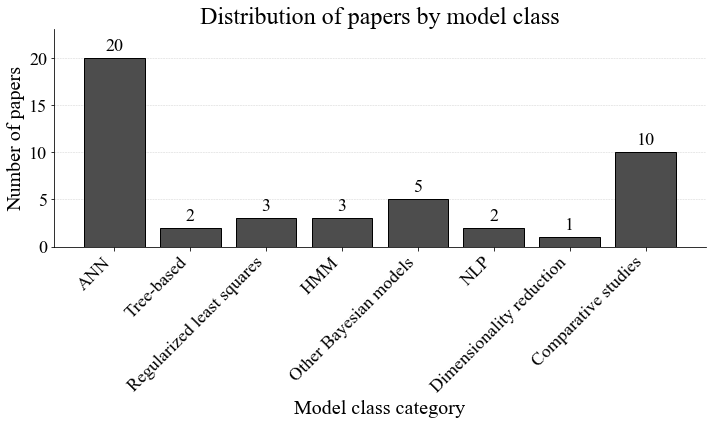

In [9]:
# Categorize model classes and plot their frequency
model_class_series = df_papers["Model class"]


def categorize_model_class(raw_value: str) -> str:
    value = str(raw_value).strip()
    if value == "ANN":
        return "ANN"
    if value == "Tree-based":
        return "Tree-based"
    if value == "Regularized least squares":
        return "Regularized least squares"
    if value.startswith("Comparative"):
        suffix = value.split(" ", 1)[1]
        return  "Comparative studies"
    if value == "HMM":
        return "HMM"
    if value == "Other Bayesian models":
        return "Other Bayesian models"
    if value == "NLP":
        return "NLP"
    if value == "Dimensionality reduction":
        return "Dimensionality reduction"
    return "Other (unspecified)"

category_order = [
    "ANN",
    "Tree-based",
    "Regularized least squares",
    "HMM",
    "Other Bayesian models",
    "NLP",
    "Dimensionality reduction",
    "Comparative studies",
]

model_class_categories = model_class_series.map(categorize_model_class)
category_counts = (
    model_class_categories.value_counts()
    .reindex(category_order, fill_value=0)
    .to_dict()
)

plot_bar_from_dict(
    category_counts,
    x_label="Model class category",
    y_label="Number of papers",
    title="Distribution of papers by model class",
    sort_by=None,
    title_fontsize=24,
    label_fontsize=20,
    tick_label_fontsize=18,
    annotation_fontsize=18,
)
plt.show()
